<a href="https://colab.research.google.com/github/Shakir-ahmed1/colab_notebooks/blob/main/amharic_stt/sequential_shared_STT_finetunning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ==================== Setup & Dependencies ====================
!pip install git+https://github.com/openai/whisper.git
!pip install torchaudio librosa datasets jiwer evaluate
!apt-get install -y ffmpeg

import os
import shutil
import subprocess
import sys
import gdown

def install_unrar():
    print("Installing 'unrar' utility...")
    try:
        !apt-get update > /dev/null 2>&1
        !apt-get install unrar -y > /dev/null 2>&1
        print("'unrar' installed successfully.")
    except Exception as e:
        print(f"Error installing 'unrar': {e}")
        sys.exit(1)

def download_from_drive(share_url, output_path):
    try:
        file_id = share_url.split('/d/')[1].split('/')[0]
        gdown.download(f'https://drive.google.com/uc?id={file_id}', output_path, quiet=False)
        print(f"Downloaded file to {output_path}")
    except Exception as e:
        print(f"Error downloading from Google Drive: {e}")
        sys.exit(1)

def extract_rar_file(file_path, extract_to):
    try:
        if os.path.exists(extract_to):
            shutil.rmtree(extract_to)
            print(f"Deleted existing directory at {extract_to}")
        os.makedirs(extract_to, exist_ok=True)
        result = subprocess.run(['unrar', 'x', '-y', file_path, extract_to + '/'],
                                capture_output=True, text=True)
        if result.returncode == 0:
            print(f"Extracted {file_path} to {extract_to}")
        else:
            raise RuntimeError(result.stderr)
    except Exception as e:
        print(f"Error extracting {file_path}: {e}")

install_unrar()

rar_url = 'https://drive.google.com/file/d/1JR3CBp_gWAv5FtgSbb9eM76k63ivxNJh/view?usp=sharing'
local_rar_path = '/content/preprocessed_dataset.rar'
extract_to_path = '/content/preprocessed_dataset'

download_from_drive(rar_url, local_rar_path)
extract_rar_file(local_rar_path, extract_to_path)




  Cloning https://github.com/openai/whisper.git to /tmp/pip-req-build-z7bbfq5m
  Running command git clone --filter=blob:none --quiet https://github.com/openai/whisper.git /tmp/pip-req-build-z7bbfq5m
  Resolved https://github.com/openai/whisper.git to commit dd985ac4b90cafeef8712f2998d62c59c3e62d22
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.8 MB/s eta 0:00:00
   ━━━━

Downloading...
From (original): https://drive.google.com/uc?id=1JR3CBp_gWAv5FtgSbb9eM76k63ivxNJh
From (redirected): https://drive.google.com/uc?id=1JR3CBp_gWAv5FtgSbb9eM76k63ivxNJh&confirm=t&uuid=aa5a32c0-3f5e-4fb1-bdfc-3524d0eba2f9
To: /content/preprocessed_dataset.rar
100%|██████████| 2.33G/2.33G [00:18<00:00, 129MB/s]


Downloaded file to /content/preprocessed_dataset.rar
Extracted /content/preprocessed_dataset.rar to /content/preprocessed_dataset


In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


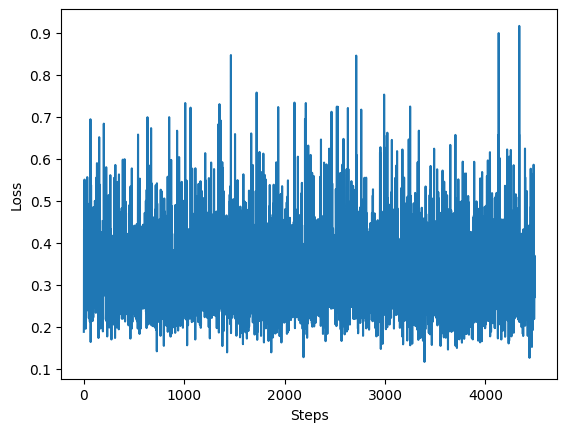

Epoch 6:  62%|██████▏   | 1734/2801 [1:40:44<1:01:55,  3.48s/it]

In [ ]:
# ==================== Dataset & Preprocessing ====================
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from datasets import Dataset
from torch.utils.data import DataLoader
from transformers import WhisperTokenizer, WhisperFeatureExtractor, WhisperForConditionalGeneration
from peft import LoraConfig, get_peft_model, PeftModel
import evaluate
import librosa
from IPython.display import clear_output

shared_drive_dir = "/content/drive/MyDrive/whisper_lora_shared"
os.makedirs(shared_drive_dir, exist_ok=True)
checkpoint_path = os.path.join(shared_drive_dir, "checkpoint.pth")

dataset_dir = '/content/preprocessed_dataset/dataset'
tsv_file_path = os.path.join(dataset_dir, 'data.tsv')
audio_dir = os.path.join(dataset_dir, 'recordings')

if not os.path.exists(tsv_file_path) or not os.path.exists(audio_dir):
    print("Dataset missing. Exiting.")
    sys.exit(1)

df = pd.read_csv(tsv_file_path, sep='\t', encoding='utf-8')
df['path'] = df['path'].apply(lambda x: os.path.join(audio_dir, os.path.basename(x)))
dataset = Dataset.from_pandas(df)
train_test_split = dataset.train_test_split(test_size=0.01, seed=42)
train_data = train_test_split['train']
test_data = train_test_split['test']

tokenizer = WhisperTokenizer.from_pretrained("openai/whisper-small", language='amharic', task='transcribe')
feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-small")
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small").to('cuda')

lora_config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=["q_proj", "v_proj", "out_proj"],
    lora_dropout=0.05,
    bias="none"
)
model = get_peft_model(model, lora_config)

class WhisperTrainingDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, max_len=300):
        self.dataset = dataset
        self.max_len = max_len

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        try:
            audio_data, _ = librosa.load(item['path'], sr=16000)
        except:
            audio_data = np.zeros(16000)
        input_features = feature_extractor(audio_data, sampling_rate=16000, return_tensors='pt').input_features[0]
        labels = tokenizer(item['sentence'], padding="max_length", max_length=self.max_len,
                           truncation=True, return_tensors="pt")
        labels = labels["input_ids"].masked_fill(labels['attention_mask'].ne(1), -100)[0][1:]
        return {"input_features": input_features, "labels": labels}

train_dataset = WhisperTrainingDataset(train_data)
test_dataset = WhisperTrainingDataset(test_data)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8)

# ==================== Evaluation & Checkpoint Functions ====================
wer_metric = evaluate.load("wer")

def evaluate_model(model, dataloader):
    model.eval()
    predictions, references = [], []
    for batch in tqdm(dataloader, desc="Evaluating"):
        input_features = batch["input_features"].to('cuda')
        labels = batch["labels"].to('cuda')
        with torch.no_grad():
            generated_tokens = model.generate(input_features=input_features, language='amharic', task='transcribe')
        predictions += tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
        references += tokenizer.batch_decode(labels, skip_special_tokens=True)
    return wer_metric.compute(predictions=predictions, references=references) * 100

def save_checkpoint(model, optimizer, epoch, global_step, loss):
    torch.save({
        'epoch': epoch,
        'global_step': global_step,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }, checkpoint_path)
    print(f"Checkpoint saved to {checkpoint_path}")

def load_checkpoint(model, optimizer):
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        print(f"Loaded checkpoint from epoch {checkpoint['epoch']+1}, step {checkpoint['global_step']}")
        return checkpoint['epoch'], checkpoint['global_step'], checkpoint['loss']
    print("No checkpoint found, starting fresh.")
    return 0, 0, None

# ==================== Training ====================
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
max_epochs = 8
running_loss, running_wer = [], []
global_step = 0
steps_per_epoch = len(train_dataloader)
checkpoint_interval = 100

start_epoch, global_step, last_loss = load_checkpoint(model, optimizer)
if last_loss: running_loss.append(last_loss)

batches_to_skip = global_step % steps_per_epoch if global_step > 0 else 0

for epoch in range(start_epoch, max_epochs):
    batch_iterator = iter(train_dataloader)
    if epoch == start_epoch:
        for _ in range(batches_to_skip): next(batch_iterator, None)

    for batch in tqdm(batch_iterator, desc=f"Epoch {epoch+1}"):
        model.train()
        input_features = batch["input_features"].to('cuda')
        labels = batch["labels"].to('cuda')
        loss = model(input_features, labels=labels).loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        global_step += 1
        running_loss.append(loss.item())

        if global_step % 50 == 0:
            plt.plot(running_loss)
            plt.xlabel("Steps")
            plt.ylabel("Loss")
            clear_output(wait=True)
            plt.show()

        # if global_step % 100 == 0:
        #     model.save_pretrained(os.path.join(shared_drive_dir, "lora_model_amharic"))
        #     save_checkpoint(model, optimizer, epoch, global_step, loss.item())

    save_checkpoint(model, optimizer, epoch, global_step, loss.item())
    wer = evaluate_model(model, test_dataloader)
    running_wer.append(wer)
    print(f"Epoch {epoch+1} WER: {wer:.2f}%")
    torch.cuda.empty_cache()

# ==================== Save Final Model ====================
model.save_pretrained(os.path.join(shared_drive_dir, "lora_model_amharic_final"))
print("✅ Final model saved.")

# ==================== Inference Examples ====================
print("\n🔍 Running inference on test samples...")
model.eval()
for idx in range(min(5, len(test_data))):
    item = test_data[idx]
    audio_data, _ = librosa.load(item['path'], sr=16000)
    input_features = feature_extractor(audio_data, sampling_rate=16000, return_tensors='pt').input_features.to('cuda')
    with torch.no_grad():
        generated_tokens = model.generate(input_features, language='amharic', task='transcribe')
    text_pred = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)[0]
    print(f"▶ Sample {idx}:\nTrue : {item['sentence']}\nPred.: {text_pred}\n")

# ==================== Visualize Token Lengths ====================
token_lengths = [len(tokenizer(text).input_ids) for text in train_data['sentence']]
plt.hist(token_lengths, bins=30)
plt.xlabel("Sentence Length (Tokens)")
plt.ylabel("Count")
plt.title("Token Length Distribution")
plt.show()


In [ ]:

# # ==================== Inference Examples ====================
# print("\n🔍 Running inference on test samples...")
# model.eval()
# for idx in range(min(5, len(test_data))):
#     item = test_data[idx]
#     audio_data, _ = librosa.load(item['path'], sr=16000)
#     input_features = feature_extractor(audio_data, sampling_rate=16000, return_tensors='pt').input_features.to('cuda')
#     with torch.no_grad():
#         generated_tokens = model.generate(input_features, language='amharic', task='transcribe')
#     text_pred = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)[0]
#     print(f"▶ Sample {idx}:\nTrue : {item['sentence']}\nPred.: {text_pred}\n")

# ==================== Inference Examples ====================
import random

print("\n🔍 Running inference on 5 random test samples...")
model.eval()

random_samples = random.sample(list(test_data), k=5)

for idx, item in enumerate(random_samples):
    try:
        audio_data, _ = librosa.load(item['path'], sr=16000)
        input_features = feature_extractor(audio_data, sampling_rate=16000, return_tensors='pt').input_features.to('cuda')

        with torch.no_grad():
            generated_tokens = model.generate(input_features, language='amharic', task='transcribe')

        text_pred = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)[0]
        print(f"▶ Sample {idx + 1}:\nTrue : {item['sentence']}\nPred.: {text_pred}\n")

    except Exception as e:
        print(f"⚠️ Error processing sample {idx + 1}: {e}")


# ==================== Visualize Token Lengths ====================
token_lengths = [len(tokenizer(text).input_ids) for text in train_data['sentence']]
plt.hist(token_lengths, bins=30)
plt.xlabel("Sentence Length (Tokens)")
plt.ylabel("Count")
plt.title("Token Length Distribution")
plt.show()